In [1]:
# Own Packages
from Masterarbeit_utils.model_utils import load_pretrained_model, load_pretrained_Tokenizer

# Site Packages
import torch
import numpy as np
import os
import sys
import pickle as pk
import pandas as pd
import bokeh
import time
from matplotlib import pyplot as plt

# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import gridplot
from bokeh.io import export_png

from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset

%matplotlib inline
output_notebook()

2023-08-15 13:32:14.611527: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 13:32:14.631172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 13:32:15.079250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading BokehJS ...

In [2]:
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'opt_30000_nochange'
checkpoint = 'no_checkpoint'

# This folder will be created and filled with txt.files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'opt large'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cpu'

# Number of GPUs the model will be parallelised to 
num_gpus = 0
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False

# Start idx = 0 if tokenizer.decode does not add a start-token, if it adds a start-token start_idx = 1
start_idx = 1

#########################
# Loading the Model
#########################
model = load_pretrained_model(base_model_name, default_dtype, tensor_parallel, num_gpus)


#########################
# Loading the Tokenizer
#########################
tokenizer = load_pretrained_Tokenizer(base_model_name)

############################
# Extracting the Embeddings
############################
out_emb = model.get_output_embeddings()
out_emb = next(out_emb.parameters()).detach().numpy()
# Input Embeddings
inp_emb = model.get_input_embeddings()
inp_emb = inp_emb(torch.arange(len(tokenizer))).detach().numpy()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
print(out_emb.shape, inp_emb.shape)

(50272, 7168) (50265, 7168)


In [4]:
# Calculating the TSNE representation of all output embeddigns
if os.path.isfile(f'{model_folder}/output_tsne_rep_{checkpoint}.pk'):
    with open(f'{model_folder}/output_tsne_rep_{checkpoint}.pk', 'rb') as f:
        out_tsne_rep = pk.load(f)
else:
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    out_tsne_rep = tsne.fit_transform(out_emb)
    with open(f'{model_folder}/output_tsne_rep_{checkpoint}.pk', 'wb') as f:
        pk.dump(out_tsne_rep, f)

# Calculating the TSNE representation of all input embeddigns
if os.path.isfile(f'{model_folder}/input_tsne_rep_{checkpoint}.pk'):
    with open(f'{model_folder}/input_tsne_rep_{checkpoint}.pk', 'rb') as f:
        inp_tsne_rep = pk.load(f)
else:
    tsne = TSNE(n_components=2, verbose=0, random_state=69) 
    inp_tsne_rep = tsne.fit_transform(inp_emb)
    with open(f'{model_folder}/input_tsne_rep_{checkpoint}.pk', 'wb') as f:
        pk.dump(inp_tsne_rep, f)

In [5]:
# Theme T-SNE

datasource_text = ColumnDataSource(
        data=dict(
            x = out_tsne_rep[:,0],
            y = out_tsne_rep[:,1],
            tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
        )
    )

hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>Token:</b> @tokens</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title='Text Output Embeddings')
    
plot_tsne.circle('x', 'y', size=8, fill_color='blue', 
                     alpha=0.7, line_width=0, source=datasource_text, name="Text-Tokens")

show(plot_tsne)

In [6]:
# Theme T-SNE

datasource_text = ColumnDataSource(
        data=dict(
            x = inp_tsne_rep[:,0],
            y = inp_tsne_rep[:,1],
            tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
        )
    )

hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>Token:</b> @tokens</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title='Text Input Embeddings')
    
plot_tsne.circle('x', 'y', size=8, fill_color='orange', 
                     alpha=0.7, line_width=0, source=datasource_text, name="Text-Tokens")

show(plot_tsne)

# Testing the Country/ Capital Relations

In [7]:
country_capitals = pd.read_csv('data/Staat Hauptstadt.csv', encoding='UTF-8', delimiter=';')
# Cleaning the data from multiple token Cities of states

country_token_ids = []
capital_token_ids = []

for country, capital in zip(country_capitals['Staat'], country_capitals['Hauptstadt']):
    try:
        country_tokenized = tokenizer.encode(country+' ')[start_idx:]
    except Exception:
        continue
    try:
        capital_tokenized = tokenizer.encode(capital+' ')[start_idx:]
    except Exception:
        continue

    #print(country_tokenized, capital_tokenized)
    if len(country_tokenized) != 1:
        continue
    if len(capital_tokenized) != 1:
        continue

    country_token_ids.append(country_tokenized)
    capital_token_ids.append(capital_tokenized)

for country_id, capital_id in zip(country_token_ids, capital_token_ids):
    print(tokenizer.decode(country_id))
    print(tokenizer.decode(capital_id))
    print('')


#This won't work because just one pair was found that can be encoded with just one token

# Testing the Male/ Female Relations

In [38]:
male_female_df = pd.read_csv('data/Male Female Nouns.csv', encoding='UTF-8', delimiter=';')
male_female_df

,MALE,FEMALE
0,boy,girl
1,gentleman,lady
2,husband,wife
3,fiancé,fiancée
4,man,woman
5,brother,sister
6,uncle,aunt
7,widower,widow
8,nephew,niece
9,dad,mum/mom


In [68]:



def extract_emb():
    male_female_df = pd.read_csv('data/Male Female Nouns.csv', encoding='UTF-8', delimiter=';')
    
    male = {}
    female = {}
    
    # extracting all meaningfully encoded male and female nouns
    for i, (male_noun, female_noun) in male_female_df.iterrows():
        male_noun = male_noun.strip().lower()
        female_noun = female_noun.strip().lower()
        
        male_synonyms = [' '+male_noun, male_noun+' ', male_noun]
        female_synonyms = [' '+female_noun, female_noun+' ', female_noun]
        
        male_emb = []
        female_emb = []
    
        for noun in male_synonyms:
            
            idx = tokenizer.encode(noun)[start_idx:]
            if len(idx) == 1:
                male_emb.append(out_emb[idx])
            noun = noun.capitalize()
            idx = tokenizer.encode(noun)[start_idx:]
            if len(idx) == 1:
                male_emb.append(out_emb[idx])
    
        for noun in female_synonyms:
            idx = tokenizer.encode(noun)[start_idx:]
            if len(idx) == 1:
                female_emb.append(out_emb[idx])
            noun = noun.capitalize()
            idx = tokenizer.encode(noun)[start_idx:]
            if len(idx) == 1: 
                female_emb.append(out_emb[idx])
            
            
        if len(male_emb) >= 1 and len(female_emb) >= 1:
            try:
                _ = male[male_noun]
            except KeyError:
                try:
                     _ = female[female_noun]
                except KeyError:
                    #print(male_noun, female_noun, len(female_emb), len(male_emb))
                    male[male_noun] = male_emb[:1]
                    female[female_noun] = female_emb[:1]
                    #print(male.keys(), female.keys())

    return male, female

male, female = extract_emb()

len(male), len(female)

(13, 13)

In [69]:
def test_prediction(test_pair):
    male, female = extract_emb()
    test_male = male.pop(test_pair[0])
    test_female = female.pop(test_pair[1])
    #print('M:', test_pair[0], 'KEYS', male.keys())
    male_emb = np.concatenate([i for item in male.values() for i in item], 0)
    female_emb = np.concatenate([i for item in female.values() for i in item], 0)
    
    
    
    std_male = np.std(male_emb, axis=0)
    mean_male = np.mean(male_emb, axis=0)
    std_female = np.std(female_emb, axis=0)
    mean_female = np.mean(female_emb, axis=0)
    
    male_idx = np.argsort(std_male)
    female_idx = np.argsort(std_female)

    test_mtf = np.array(test_male)[0][0]
    mean_diff = mean_female - mean_male
    test_mtf[female_idx[:]] += mean_diff[female_idx[:]]
    
    cos = torch.nn.CosineSimilarity(dim = 1)
    
    print(f'''
{test_pair[0]} {test_pair[1]}:
    Similarity test_male - test_female: {cos(torch.tensor(test_male[0]), torch.tensor(test_female[0])).item():.5f}
    Similarity test_mtf - test_female: {cos(torch.tensor(test_mtf), torch.tensor(test_female[0])).item():.5f}
    Increase: {cos(torch.tensor(test_mtf), torch.tensor(test_female[0])).item() - cos(torch.tensor(test_male[0]), torch.tensor(test_female[0])).item():.5f}
    
    ''')

In [70]:
m, f = extract_emb()

for male, female in zip(m.keys(), f.keys()):
    test_prediction((male, female))


boy girl:
    Similarity test_male - test_female: 0.48544
    Similarity test_mtf - test_female: 0.60399
    Increase: 0.11854
    
    

gentleman lady:
    Similarity test_male - test_female: 0.36338
    Similarity test_mtf - test_female: 0.47155
    Increase: 0.10817
    
    

husband wife:
    Similarity test_male - test_female: 0.54842
    Similarity test_mtf - test_female: 0.57503
    Increase: 0.02660
    
    

man woman:
    Similarity test_male - test_female: 0.38358
    Similarity test_mtf - test_female: 0.51569
    Increase: 0.13212
    
    

brother sister:
    Similarity test_male - test_female: 0.56640
    Similarity test_mtf - test_female: 0.64746
    Increase: 0.08106
    
    

uncle aunt:
    Similarity test_male - test_female: 0.54963
    Similarity test_mtf - test_female: 0.60919
    Increase: 0.05956
    
    

nephew niece:
    Similarity test_male - test_female: 0.60545
    Similarity test_mtf - test_female: 0.66162
    Increase: 0.05618
    
    

father mot

In [9]:
male_emb = np.concatenate([i for item in male.values() for i in item], 0)
    female_emb = np.concatenate([i for item in female.values() for i in item], 0)
    
    
    
    std_male = np.std(male_emb, axis=0)
    mean_male = np.mean(male_emb, axis=0)
    std_female = np.std(female_emb, axis=0)
    mean_female = np.mean(female_emb, axis=0)
    
    male_idx = np.argsort(std_male)
    female_idx = np.argsort(std_female)
    
    #for midx, mstd, mmean, fidx, fstd, fmean in zip(male_idx, std_male, mean_male, female_idx, std_female, mean_female):
    #    print(f'Male:: Index: {midx :.3f} Standard-Deviation: {mstd:.3f} Mean: {mmean:.3f}')
    #    print(f'Female:: Index: {fidx :.3f} Standard-Deviation: {fstd:.3f} Mean: {fmean:.3f}')
    
    describing_dimensions = np.intersect1d(male_idx[:30], female_idx[:30])
    
    for idx in describing_dimensions:
        print(f'Index: {idx}, Male mean: {mean_male[idx]:.4f}, Male STD: {std_male[idx]:.4f}, Female mean: {mean_female[idx]:.4f}, Female STD: {std_female[idx]:.4f}, Diff: {mean_female[idx] - mean_male[idx]:.4f}')
        

Index: 845, Male mean: -0.0010, Male STD: 0.0062, Female mean: 0.0024, Female STD: 0.0074, Diff: 0.0035
Index: 1204, Male mean: 0.0003, Male STD: 0.0055, Female mean: 0.0018, Female STD: 0.0053, Diff: 0.0016
Index: 1422, Male mean: -0.0009, Male STD: 0.0062, Female mean: -0.0023, Female STD: 0.0057, Diff: -0.0014
Index: 1651, Male mean: 0.0018, Male STD: 0.0058, Female mean: 0.0041, Female STD: 0.0052, Diff: 0.0024
Index: 1731, Male mean: -0.0038, Male STD: 0.0060, Female mean: -0.0064, Female STD: 0.0052, Diff: -0.0027
Index: 2777, Male mean: 0.0032, Male STD: 0.0090, Female mean: 0.0075, Female STD: 0.0074, Diff: 0.0043
Index: 5536, Male mean: 0.0060, Male STD: 0.0086, Female mean: 0.0041, Female STD: 0.0061, Diff: -0.0019
Index: 5663, Male mean: -0.0018, Male STD: 0.0085, Female mean: 0.0013, Female STD: 0.0074, Diff: 0.0031
Index: 6570, Male mean: -0.0093, Male STD: 0.0087, Female mean: -0.0133, Female STD: 0.0074, Diff: -0.0041
Index: 6954, Male mean: 0.0010, Male STD: 0.0070, Fem

In [11]:
test_mtf = np.array(test_male)[0][0]
mean_diff = mean_female - mean_male
test_mtf[female_idx[:]] += mean_diff[female_idx[:]]


print(test_mtf.shape, test_male[0].shape)

cos = torch.nn.CosineSimilarity(dim = 1)

print(f'Similarity test_male - test_female: {cos(torch.tensor(test_male[0]), torch.tensor(test_female[0]))}, Similarity test_mtf - test_female: {cos(torch.tensor(test_mtf), torch.tensor(test_female[0]))}')

(7168,) (1, 7168)
Similarity test_male - test_female: tensor([0.5664]), Similarity test_mtf - test_female: tensor([0.6440])


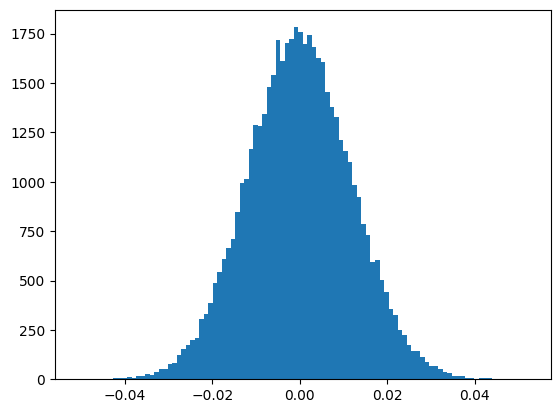

In [74]:
r1 = torch.randn(out_emb.shape)
r2 = torch.randn(out_emb.shape)

s = cos(r1, r2)

plt.hist(s, bins=100)
plt.show()

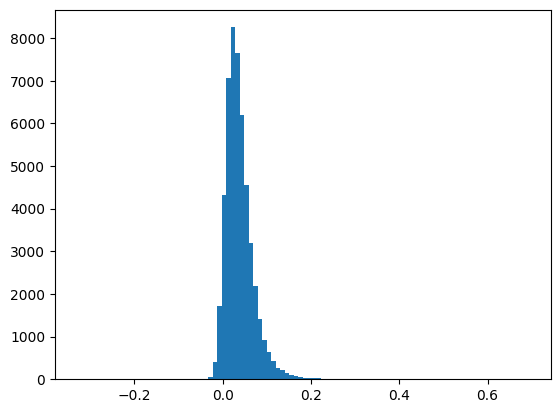

In [90]:
mix_emb = [out_emb[100:], out_emb[:100]]
mix_emb = np.concatenate(mix_emb, 0)
se = cos(torch.tensor(out_emb), torch.tensor(mix_emb))

plt.hist(se, bins=100)
plt.show()